In [7]:
!python -V

Python 3.10.10


In [2]:
!mlflow --version

mlflow, version 2.2.2


In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pickle

In [9]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [10]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-yello-taxi-experiment")

2023/05/30 08:49:44 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2023/05/30 08:49:44 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


<Experiment: artifact_location='/home/singh/mlops-zoomcamp-2023/02-experiment-tracking/training/mlruns/2', creation_time=1685173613378, experiment_id='2', last_update_time=1685173613378, lifecycle_stage='active', name='nyc-yello-taxi-experiment', tags={}>

In [11]:
df = pd.read_parquet("../../data/yellow_tripdata_2022-01.parquet")

In [12]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.0,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.0,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.5,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0


In [27]:
df.shape

(2463931, 19)

In [28]:
len(df.columns)

19

In [29]:
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds()/60)

/tmp/ipykernel_86010/3426635498.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.duration)


<Axes: xlabel='duration', ylabel='Density'>

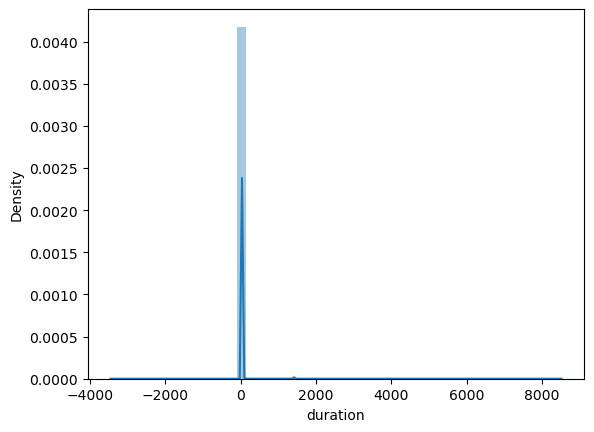

In [30]:
sns.distplot(df.duration)

In [31]:
df.duration.describe().round(2)

count    2463931.00
mean          14.21
std           46.45
min        -3442.40
25%            6.32
50%           10.18
75%           16.17
max         8513.18
Name: duration, dtype: float64

In [32]:
df.duration.describe(percentiles=[0.95, 0.98, 0.99]).round()

count    2463931.0
mean          14.0
std           46.0
min        -3442.0
50%           10.0
95%           32.0
98%           42.0
99%           51.0
max         8513.0
Name: duration, dtype: float64

In [33]:
((df.duration >= 1) & (df.duration <= 60 )).mean()

0.9827547930522406

In [34]:
df = df[(df.duration >= 1) & (df.duration <= 60 )].copy()

In [35]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [36]:
df[categorical] = df[categorical].astype(str)

In [37]:
train_dicts = df[categorical].to_dict(orient='records')

In [38]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [39]:
len(dv.feature_names_)

515

In [40]:
target = 'duration'

In [41]:
y_train=df[target].values

In [42]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [43]:
y_pred = lr.predict(X_train)

/tmp/ipykernel_86010/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_86010/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


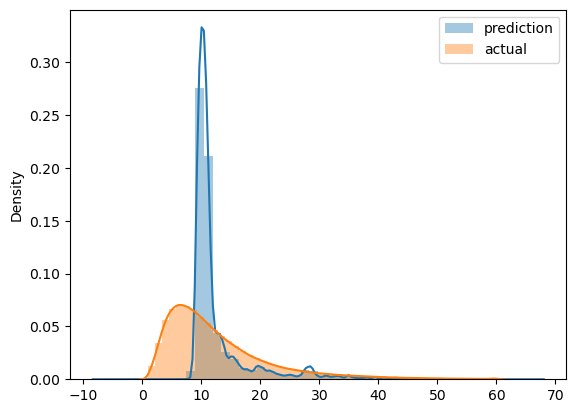

In [44]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [45]:
mean_squared_error(y_train, y_pred, squared=False).round(2)

6.99

In [11]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    
    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    
    df = df[(df.duration >= 1) & (df.duration <= 60 )].copy()
    
    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [12]:
df_train = read_dataframe("../data/yellow_tripdata_2022-01.parquet")
df_val = read_dataframe("../data/yellow_tripdata_2022-02.parquet")

In [12]:
len(df_train), len(df_val)

(2421440, 2918187)

In [13]:
dv = DictVectorizer()
categorical = ['PULocationID', 'DOLocationID']

train_dicts = df_train[categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [14]:
target = 'duration'
y_train=df_train[target].values
y_val=df_val[target].values

In [15]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False).round(2)

7.79

In [19]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [10]:
with mlflow.start_run():
    mlflow.set_tag("developer", "shubh")
    mlflow.log_param("train_data_path", "../data/yellow_tripdata_2022-01.parquet")
    mlflow.log_param("validation_data_path", "../data/yellow_tripdata_2022-02.parquet")

    alpha = 0.1
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

KeyboardInterrupt: 

## Adding trip distance as a feature

In [52]:
dv = DictVectorizer()
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [53]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False).round(2)

7.8

## Using filtered data

In [3]:
def read_filtered_dataframe(filename):
    df = pd.read_parquet(filename)
    
    # Only using credit card trips and standard rate
    df = df[(df.payment_type==1) & (df.RatecodeID==1)].copy()
    # Only using one vendor
    # df = df[(df.VendorID==1)].copy()
    
    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    
    df = df[(df.duration >= 1) & (df.duration <= 60 )].copy()
    
    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [5]:
df_filter_train = read_filtered_dataframe("../../data/yellow_tripdata_2022-01.parquet")
df_filter_val = read_filtered_dataframe("../../data/yellow_tripdata_2022-02.parquet")

In [6]:
dv = DictVectorizer()
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

train_filter_dicts = df_filter_train[categorical + numerical].to_dict(orient='records')
X_filter_train = dv.fit_transform(train_filter_dicts)

val_filter_dicts = df_filter_val[categorical + numerical].to_dict(orient='records')
X_filter_val = dv.transform(val_filter_dicts)

In [7]:
target = 'duration'
y_filter_train = df_filter_train[target].values
y_filter_val = df_filter_val[target].values

In [13]:
lr = LinearRegression()
lr.fit(X_filter_train, y_filter_train)

y_filter_pred = lr.predict(X_filter_val)
mean_squared_error(y_filter_val, y_filter_pred, squared=False).round(2)

5.47

In [15]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [16]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [15]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params = params,
            dtrain = train,
            num_boost_round = 1000,
            evals = [(valid, "validation")],
            early_stopping_rounds = 50
        )

        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [16]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 20, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42,
}

In [17]:
best_result = fmin(
    fn = objective,
    space = search_space,
    algo = tpe.suggest,
    max_evals = 5,
    trials = Trials()
)

[01:46:04] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:14.07666                         
[1]	validation-rmse:12.32398                         
[2]	validation-rmse:11.02503                         
[3]	validation-rmse:10.08818                         
[4]	validation-rmse:9.41506                          
[5]	validation-rmse:8.86546                          
[6]	validation-rmse:8.51711                          
[7]	validation-rmse:8.26406                          
[8]	validation-rmse:8.07897                          
[9]	validation-rmse:7.92886                          
[10]	validation-rmse:7.74477                         
[11]	validation-rmse:7.66582                         
[12]	validation-rmse:7.60108                         
[13]	validation-rmse:7.54744                         
[14]	validation-rmse:7.49598                         
[15]	validation-rmse:7.46050                         
[16]	validation-r

In [21]:
best_params = {
    'learning_rate':0.708641828554593,
    'max_depth':14,
    'min_child_weight':0.4426130228647856,
    'objective':'reg:linear',
    'reg_alpha':0.21891506966388866,
    'reg_lambda':0.005926892182161813,
    'seed':42
    }

mlflow.xgboost.autolog()

booster = xgb.train(
    params = best_params,
    dtrain = train,
    num_boost_round = 200,
    evals = [(valid, "validation")],
    early_stopping_rounds = 50
)


2023/05/30 09:37:39 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.


[09:37:39] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:9.45790
[1]	validation-rmse:8.16383
[2]	validation-rmse:7.80161
[3]	validation-rmse:7.63916
[4]	validation-rmse:7.55887
[5]	validation-rmse:7.43653
[6]	validation-rmse:7.27055
[7]	validation-rmse:7.20761
[8]	validation-rmse:7.17080
[9]	validation-rmse:7.13164
[10]	validation-rmse:7.10719
[11]	validation-rmse:7.06000
[12]	validation-rmse:6.89603
[13]	validation-rmse:6.88399
[14]	validation-rmse:6.86352
[15]	validation-rmse:6.84091
[16]	validation-rmse:6.80271
[17]	validation-rmse:6.78521
[18]	validation-rmse:6.76780
[19]	validation-rmse:6.74378
[20]	validation-rmse:6.63943
[21]	validation-rmse:6.60479
[22]	validation-rmse:6.59234
[23]	validation-rmse:6.57407
[24]	validation-rmse:6.55515
[25]	validation-rmse:6.54574
[26]	validation-rmse:6.53845
[27]	validation-rmse:6.52895
[28]	validation-rmse:6.46319
[29]	validation-rmse:6.36146
[30]	validation-rmse:

2023/05/30 09:40:40 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.


In [22]:
mlflow.xgboost.autolog(disable=True)

In [25]:
best_params = {
    'learning_rate':0.708641828554593,
    'max_depth':14,
    'min_child_weight':0.4426130228647856,
    'objective':'reg:linear',
    'reg_alpha':0.21891506966388866,
    'reg_lambda':0.005926892182161813,
    'seed':42
    }

mlflow.log_params(best_params)

booster = xgb.train(
    params = best_params,
    dtrain = train,
    num_boost_round = 100,
    evals = [(valid, "validation")],
    early_stopping_rounds = 50
)

y_pred = booster.predict(valid)
rmse = mean_squared_error(y_val, y_pred, squared=False)
mlflow.log_metric("rmse", rmse)

with open("models/preprocessor.b", "wb") as f_out:
    pickle.dump(dv, f_out)

mlflow.log_artifact(local_path="models/preprocessor.b", artifact_path= "preprocessor")

mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

[10:04:32] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:9.45790
[1]	validation-rmse:8.16383
[2]	validation-rmse:7.80161
[3]	validation-rmse:7.63916
[4]	validation-rmse:7.55887
[5]	validation-rmse:7.43653
[6]	validation-rmse:7.27055
[7]	validation-rmse:7.20761
[8]	validation-rmse:7.17080
[9]	validation-rmse:7.13164
[10]	validation-rmse:7.10719
[11]	validation-rmse:7.06000
[12]	validation-rmse:6.89603
[13]	validation-rmse:6.88399
[14]	validation-rmse:6.86352
[15]	validation-rmse:6.84091
[16]	validation-rmse:6.80271
[17]	validation-rmse:6.78521
[18]	validation-rmse:6.76780
[19]	validation-rmse:6.74378
[20]	validation-rmse:6.63943
[21]	validation-rmse:6.60479
[22]	validation-rmse:6.59234
[23]	validation-rmse:6.57407
[24]	validation-rmse:6.55515
[25]	validation-rmse:6.54574
[26]	validation-rmse:6.53845
[27]	validation-rmse:6.52895
[28]	validation-rmse:6.46319
[29]	validation-rmse:6.36146
[30]	validation-rmse:

In [26]:
logged_model = 'runs:/eb99258b3f2243a9b96a602a34b8c795/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

[10:10:04] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [27]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: eb99258b3f2243a9b96a602a34b8c795

In [28]:
xgboost_model = mlflow.xgboost.load_model(logged_model)

[10:10:30] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [29]:
xgboost_model

In [30]:
ypred = xgboost_model.predict(valid)

In [31]:
ypred[:10]

array([14.82516 , 19.603016, 27.413166, 21.90948 , 29.546425, 14.103423,
       29.862238,  6.074879, 17.467766, 13.842957], dtype=float32)

In [32]:
from sklearn.ensemble import GradientBoostingRegressor

In [41]:
#mlflow.end_run()

In [42]:

mlflow.sklearn.autolog()
reg = GradientBoostingRegressor(random_state=0)
with mlflow.start_run() as run:
    reg.fit(X_train, y_train)

y_pred = reg.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

2023/05/30 12:27:30 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.


8.038019965916726